In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Loading the formulated train data**

In [27]:
df=pd.read_csv("final_train.csv")

In [28]:
df.drop(['ID'],axis=1,inplace=True)

In [29]:
df.head(10)

,Region_Code,Upper_Age,Lower_Age,Health Indicator,Reco_Policy_Cat,Reco_Policy_Premium,Response,Accomodation_Type_Rented,Reco_Insurance_Type_Joint,Is_Spouse_Yes,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9
0,3213,36,36,1,22,11628.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1117,75,22,2,22,30510.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,3732,32,32,2,19,7450.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4378,52,48,1,19,17780.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2190,44,44,2,16,10404.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,1785,52,52,2,22,15264.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,679,28,28,2,17,10640.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,3175,75,73,4,17,29344.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,3497,52,43,1,1,27283.2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,530,59,26,2,18,21100.8,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Load the formulated test data**

In [30]:
df_test=pd.read_csv("final_test.csv")

In [31]:
df_test.drop(['ID'],axis=1,inplace=True)

In [32]:
X_test = df_test

**Seperate the independet and dependent variable**

In [33]:
X=df.drop(['Response'],axis=1)
y=df['Response']

**Visulizing the corelation with help of a heatmap**

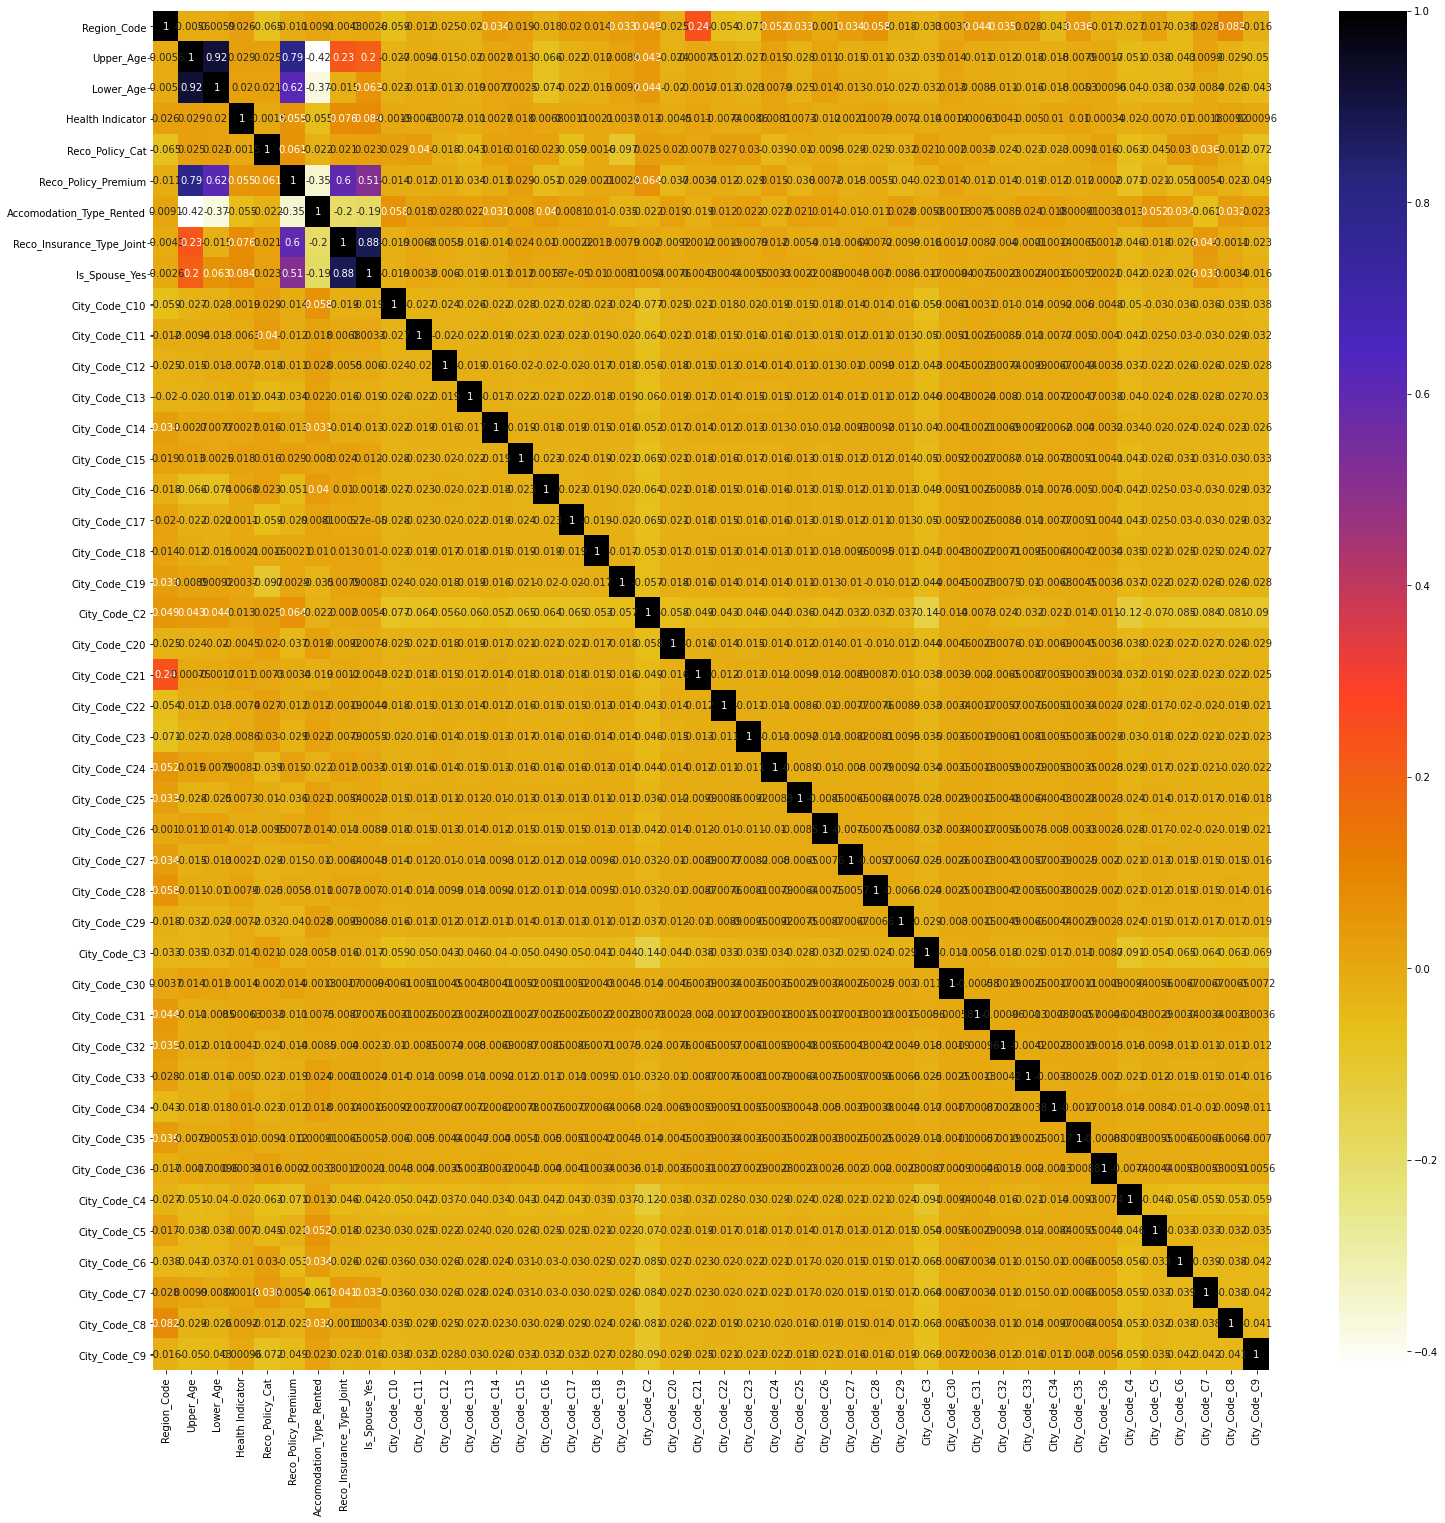

In [34]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(25,25))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [35]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [37]:
corr_features = correlation(X, 0.8)
len(set(corr_features))

2

In [38]:
corr_features

{'Is_Spouse_Yes', 'Lower_Age'}

**Removing higly corelated feature from test and train data**

In [39]:
X=X.drop(corr_features,axis=1)
X_test = X_test.drop(corr_features,axis=1)

**Scaling the dataset**

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)

**Applying XGoost**

In [41]:
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [42]:
param_test = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 100]
}
gsearch = GridSearchCV(estimator = 
XGBClassifier(learning_rate =0.05,
              n_estimators=200,
              max_depth=7,
              min_child_weight=1,
              gamma=0.1,
              subsample=0.85,
              colsample_bytree=0.8,
              objective= 'binary:logistic',
              nthread=4,
              scale_pos_weight=1,
              seed=27), 
              param_grid = param_test,
              scoring='roc_auc',
              n_jobs=4,
              iid=False, 
              cv=2,
              verbose=10)

gsearch.fit(X,y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   8 | elapsed:   38.2s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   3 out of   8 | elapsed:   38.2s remaining:  1.1min
[Parallel(n_jobs=4)]: Done   4 out of   8 | elapsed:   40.1s remaining:   40.1s
[Parallel(n_jobs=4)]: Done   5 out of   8 | elapsed:  1.1min remaining:   40.1s
[Parallel(n_jobs=4)]: Done   6 out of   8 | elapsed:  1.1min remaining:   22.7s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  1.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.1,
                                     learning_rate=0.05, max_delta_step=0,
                                     max_depth=7, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.85, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=10)

In [43]:
# probability of getting output as 1 

predictions3=gsearch.predict_proba(X_test)[:,1]
predictions3

array([0.23749396, 0.21695681, 0.28150102, ..., 0.00688477, 0.20400621,
       0.10080423], dtype=float32)

**Making the submission file**

In [44]:
pred=pd.DataFrame(predictions3)
sub_df=pd.read_csv('sample_submission_QrCyCoT.csv')
datasets=pd.concat([sub_df['ID'],pred],axis=1)
datasets.columns=['ID','Response']
datasets

,ID,Response
0,50883,0.237494
1,50884,0.216957
2,50885,0.281501
3,50886,0.194222
4,50887,0.222171
...,...,...
21800,72683,0.264983
21801,72684,0.224904
21802,72685,0.006885
21803,72686,0.204006


In [46]:
datasets.to_csv('final_submission5.csv',index=False)